In [110]:
import json
import os
import shutil
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from ultralytics.utils.plotting import Annotator



In [111]:
class DentexDataset:
    """A class for loading and processing dental x-ray images.

    Args:
        root_dir: The path to the root directory of the dataset.
        train: Whether to load the training or validation set.
        task: The task to perform on the dataset.
        sample: Whether to sample the dataset.

    Raises:
        ValueError: If the `task` argument is not one of `quadrant`, `quadrant_enumeration`, or `quadrant_enumeration_disease`.
    """

    def __init__(self, root_dir: Path, train=True, task='quadrant_enumeration', sample=False, ours=False):
        self.root_dir = root_dir
        self.train = train
        self.task = task

        if task not in ['quadrant', 'quadrant_enumeration', 'quadrant_enumeration_disease']:
            raise ValueError(f'Invalid task: {task}')

        if train:
            task_root_dir = self.root_dir / 'training_data' / task
            with open(task_root_dir / f'train_{task}.json') as f:
                self.json_content = json.load(f)
        else:
            task_root_dir = self.root_dir / 'validation_data' / 'quadrant_enumeration_disease'
            self.json_content = None

        self.task_root_dir = task_root_dir
        self.img_paths = list((task_root_dir / 'xrays').glob('*.png'))
        self.img_names = [i.name for i in self.img_paths]

        image_id_dict = {i['id']: i['file_name'] for i in self.json_content['images']}

        annotations = {}
        for annotation in self.json_content['annotations']:
            image_id = annotation['image_id']
            image_name = image_id_dict[image_id]
            bbox = self.xywh_to_xyxy(annotation['bbox'])
            name = f'{annotation["category_id_1"] + 1}{annotation["category_id_2"] + 1}'

            if image_name not in annotations.keys():
                annotations[image_name] = {}

            annotations[image_name][name] = np.array(bbox)

        annotations = pd.DataFrame.from_dict(annotations, orient='index')

        if sample:
            annotations = annotations.sample(frac=0.275)
        if ours:
            target_list = [''.join(i) for i in zip('11223344', '37' * 4)]
            annotations = annotations[target_list]

        self.annotations = annotations.sort_index()

        self.train_annotations = annotations.sample(frac=0.8)
        self.val_annotations = annotations[~annotations.index.isin(self.train_annotations.index)]

    def __getitem__(self, index):
        if isinstance(index, int):
            anno = self.annotations.iloc[index]
            name = anno.name
        elif isinstance(index, str):
            anno = self.annotations.loc[index]
            name = anno.name
        else:
            raise TypeError('index should be int or str.')

        im = cv2.imread(str(self.task_root_dir / 'xrays' / name))

        return im, anno

    def __len__(self):
        return len(self.annotations)

    def image_full_path(self, image_name):
        return self.task_root_dir / 'xrays' / image_name

    def plot(self, image_name):
        # im = cv2.imread(str(self.task_root_dir / 'xrays' / image_name))
        im, anno = self[image_name]

        annotator = Annotator(im, line_width=3, example=image_name)

        for tooth_number, xyxy in anno.items():
            if isinstance(xyxy, float):
                continue
            annotator.box_label(xyxy, str(tooth_number), color=(255, 0, 0))

        im1 = annotator.result()
        plt.imshow(im1)
        plt.show()

    def yolo_yaml_gen(self, path=None):
        if not path:
            path = self.task_root_dir / 'yolov8'

        image_path = path / 'images'
        label_path = path / 'labels'

        train_image = image_path / 'train'
        val_image = image_path / 'val'
        train_label = label_path / 'train'
        val_label = label_path / 'val'

        names = list(self.annotations.columns.sort_values())
        inv_names = {name: i for i, name in enumerate(names)}
        names = [f'{i}: {name}' for i, name in enumerate(names)]

        names_str = '\n  '.join(names)

        yaml_file = f'''
path: {path}
train: {train_image.relative_to(path)}
val: {val_image.relative_to(path)}

names:
  {names_str}
        '''

        def make_dirs(dirs):
            for i in dirs:
                os.mkdir(i)

        yolov8_dirs = [path, image_path, train_image, val_image, label_path, train_label, val_label]
        # Dir check & create
        if os.path.isdir(path):
            shutil.rmtree(path)
        make_dirs(yolov8_dirs)

        # YAML file gen
        with open(path / 'dentex.yaml', 'w') as f:
            f.write(yaml_file)

        # Write image and label data
        dst_triple = (
            (self.train_annotations, train_image, train_label),
            (self.val_annotations, val_image, val_label),
        )

        for anno, image_dst, label_dst in dst_triple:
            self.yolo_write_image_label_data(anno, image_dst, label_dst, inv_names)

        return path / 'dentex.yaml'

    def yolo_write_image_label_data(self, anno, image_dst, label_dst, inv_names):
        """Processes annotation and image data for tooth segmentation.

        Args:
            anno: The annotation data.
            image_dst: The destination directory for the image files.
            label_dst: The destination directory for the label files.
            inv_names: A dictionary mapping tooth names to tooth numbers.

        Returns:
            None.
        """
        index = anno.index
        for file_name in index:
            # Image file processing
            org_path = self.image_full_path(file_name)
            dst_path = image_dst / file_name

            shutil.copy(org_path, dst_path)

            # Label file processing
            im = cv2.imread(str(org_path))
            h, w, _ = im.shape

            label_rows = []
            labels = anno.loc[file_name]
            tooth_names = labels.index
            for tooth_name in tooth_names:
                label = labels[tooth_name]
                if isinstance(label, float):
                    continue

                label = self.xyxy_to_yolo_wywh(label)
                label = label / [w, h, w, h]

                label_formatted = list(map(lambda s: '%.5f' % s, label))
                label_str = ' '.join(label_formatted)

                tooth_number = inv_names[tooth_name]
                label_row = f'{tooth_number:2d} {label_str}'

                label_rows.append(label_row)

            file_name = Path(file_name)
            file_name = file_name.with_suffix('.txt')
            label_file_path = label_dst / file_name
            with open(label_file_path, 'w') as f:
                f.write('\n'.join(label_rows))

    @staticmethod
    def xywh_to_xyxy(box):
        """Converts a bounding box from xywh format to xyxy format.

        Args:
        box: A list of four numbers, representing the bounding box in xywh format.

        Returns:
        A list of four numbers, representing the bounding box in xyxy format.
        """
        box[2] = box[0] + box[2]
        box[3] = box[1] + box[3]
        return box

    @staticmethod
    def xyxy_to_xywh(box):
        """Converts a bounding box from xyxy format to xywh format.a
        
        Args:
        box: A list of four numbers, representing the bounding box in xyxy format.
        
        Returns:
        A list of four numbers, representing the bounding box in xywh format.
        """

        box[2] = box[2] - box[0]
        box[3] = box[3] - box[1]
        return box

    @staticmethod
    def xyxy_to_yolo_wywh(box):
        """
        Convert bounding box from xywh to yolo format
        
        Args:
        box: 

        Returns:
        """
        new_box = box.copy()

        new_box[0] = (box[0] + box[2]) / 2
        new_box[1] = (box[1] + box[3]) / 2
        new_box[2] = box[2] - box[0]
        new_box[3] = box[3] - box[1]

        return new_box


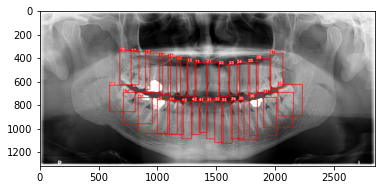

In [112]:
load_dotenv()
data_dir = Path(os.getenv('DATASET_DIR')) / 'DENTEX CHALLENGE 2023'

a = DentexDataset(root_dir=data_dir, sample=True, ours=False)

# a.annotations
image_name = a.annotations.index[0]
a.plot(image_name)


YOLOv8 YAML file generate

In [113]:
yaml_root = Path('../data/dentex-32-bound').absolute()
yaml_path = a.yolo_yaml_gen(path=yaml_root)


In [114]:
a.annotations


,11,12,13,15,16,17,18,21,22,23,...,43,44,45,47,48,14,25,34,36,46
train_1.png,"[1317.1270718232045, 439.22651933701655, 1420....","[1251.9337016574584, 428.1767955801105, 1326.5...","[1162.9834254143645, 411.0497237569061, 1256.9...","[1013.8121546961326, 380.6629834254144, 1109.3...","[895.906432748538, 357.89473684210526, 1043.27...","[774.8538011695906, 345.6140350877193, 934.502...","[678.9473684210526, 336.2573099415205, 841.520...","[1417.4496644295302, 435.5704697986577, 1524.8...","[1520.8053691275168, 451.67785234899327, 1610....","[1606.711409395973, 451.67785234899327, 1696.6...",...,"[1206.2937062937062, 768.5314685314686, 1288.8...","[1100.0, 760.352422907489, 1220.704845814978, ...","[997.0588235294117, 753.4313725490196, 1166.66...","[709.8039215686274, 691.1764705882352, 954.411...","[592.156862745098, 629.9019607843137, 808.8235...","[1088.9502762430939, 390.6077348066298, 1193.9...","[1769.832402234637, 431.8435754189944, 1853.63...","[1623.5294117647059, 757.3529411764705, 1733.8...","[1781.6176470588234, 733.0882352941176, 2009.5...","[834.8039215686274, 735.2941176470588, 1086.27..."
train_105.png,"[913.2307692307692, 322.38461538461536, 974.76...","[870.9230769230769, 314.6923076923077, 922.846...","[824.7692307692307, 308.9230769230769, 888.230...","[732.4615384615385, 312.7692307692308, 799.769...","[657.4615384615385, 293.53846153846155, 744.0,...","[578.6153846153846, 301.2307692307692, 676.692...",NaN,"[969.0, 295.46153846153845, 1034.3846153846152...","[1013.2307692307692, 282.0, 1059.3846153846152...","[1055.5384615384614, 287.7692307692308, 1095.9...",...,"[832.4615384615385, 543.5384615384615, 870.923...","[774.7692307692307, 541.6153846153846, 832.461...","[699.7692307692307, 535.8461538461538, 784.384...","[524.7692307692307, 487.7692307692307, 663.230...",NaN,"[784.3846153846154, 308.9230769230769, 851.692...","[1120.923076923077, 303.15384615384613, 1184.3...","[1051.6923076923076, 549.3076923076923, 1103.6...","[1136.3076923076924, 514.6923076923076, 1272.8...","[605.5384615384615, 516.6153846153846, 736.307..."
train_106.png,"[1341.4545454545453, 339.3636363636364, 1443.2...","[1272.3636363636363, 397.5454545454545, 1354.1...","[1196.0, 344.81818181818176, 1294.181818181818...","[1057.8181818181818, 426.6363636363636, 1168.7...","[917.8181818181818, 455.72727272727263, 1074.1...","[797.8181818181818, 439.36363636363626, 935.99...","[737.8181818181818, 424.81818181818176, 885.09...","[1435.9999999999998, 397.5454545454545, 1539.6...","[1523.2727272727273, 424.81818181818176, 1606....","[1595.9999999999998, 361.18181818181813, 1692....",...,"[1225.090909090909, 742.9999999999999, 1372.36...","[1134.181818181818, 748.4545454545454, 1254.18...","[1052.3636363636363, 748.4545454545454, 1172.3...",NaN,NaN,"[1130.5454545454545, 432.090909090909, 1256.0,...","[1735.9999999999998, 428.4545454545454, 1848.7...","[1621.4545454545453, 726.6363636363635, 1715.9...","[1755.9999999999998, 704.8181818181818, 1959.6...","[830.5454545454545, 759.3636363636363, 1050.54..."
train_109.png,"[1379.1666666666667, 400.0, 1459.7222222222222...","[1329.1666666666667, 454.1666666666667, 1380.5...","[1258.3333333333335, 383.33333333333337, 1334....","[1150.0, 356.94444444444446, 1213.888888888889...",NaN,"[926.3888888888889, 390.27777777777777, 1050.0...",NaN,"[1462.5, 420.83333333333337, 1543.055555555555...","[1538.888888888889, 426.3888888888889, 1604.16...","[1593.0555555555557, 384.72222222222223, 1680....",...,"[1240.2777777777778, 770.8333333333334, 1354.1...","[1179.1666666666667, 763.8888888888889, 1288.8...","[1088.888888888889, 741.6666666666667, 1234.72...","[780.5555555555555, 680.5555555555555, 1054.16...",NaN,NaN,NaN,NaN,NaN,NaN
train_111.png,"[1344.8275862068967, 243.1034482758621, 1491.3...","[1284.4827586206898, 231.0344827586207, 1439.6...","[1232.7586206896553, 212.0689655172414, 1337.9...","[1115.5172413793105, 270.68965517241384, 1225....","[1003.4482758620691, 289.65517241379314, 1162....","[872.4

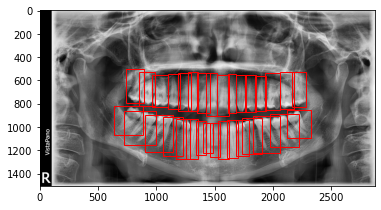

In [117]:
from matplotlib import patches
from glob import glob

image_dir = yaml_root / 'images' / 'train'
label_dir = yaml_root / 'labels' / 'train'

image_path = Path(glob(str(image_dir / '*.png'))[0]) 
image_name = image_path.name
image_stem = image_path.stem

label_path = glob(str(label_dir / f'{image_stem}*'))[0]

im = cv2.imread(str(image_path))
h, w = im.shape[0], im.shape[1]

def int_to_fdi(a):
    a += 8
    base = 8
    return a // base * 10 + a % base + 1

bboxes = {}
with open(label_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = list(map(float, line.split()))

        line[1] = line[1] * w
        line[2] = line[2] * h
        line[3] = line[3] * w
        line[4] = line[4] * h

        line[1] = line[1] - line[3] / 2
        line[2] = line[2] - line[4] / 2

        bboxes[int_to_fdi(int(line[0]))] = np.array(line[1:])

# bboxes = pd.DataFrame.from_dict(bboxes, orient='index').sort_index()
bboxes2 = a.annotations.loc[image_name].sort_index()

fig, ax = plt.subplots()
ax.imshow(im)

for _, bbox in bboxes.items():
    plt_xy = (bbox[0], bbox[1])

    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()



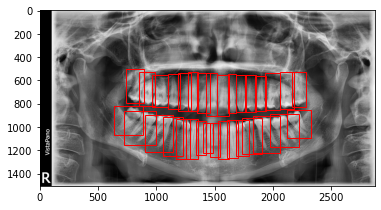

In [116]:
im = cv2.imread(str(image_path))
fig, ax = plt.subplots()
ax.imshow(im)

for bbox in bboxes2:
    if isinstance(bbox, float):
        continue

    plt_xy = (bbox[0], bbox[1])

    rect = patches.Rectangle(plt_xy, bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

